# Basic Compartmental Models

The Basic Compartmental Model divides a neuron into multiple discrete sections (compartments) connected by resistors, allowing for detailed simulation of complex neuronal morphologies. Unlike the equivalent-cylinder model, which simplifies entire dendritic trees into single cylinders with uniform properties, compartmental models preserve the actual branching structure and can incorporate different membrane properties for each compartment. This approach enables more realistic simulation of signal integration in neurons with complex geometries and heterogeneous distribution of ion channels.

## Key Properties

1. **Spatial Discretization**: Divides neuron into small, interconnected compartments
2. **Morphological Accuracy**: Represents actual neuronal geometry including branching patterns
3. **Heterogeneous Properties**: Allows different electrical properties in different compartments
4. **Distributed Computation**: Simulates local interactions between adjacent segments
5. **Scalable Complexity**: Can range from simple few-compartment models to detailed reconstructions with thousands of compartments

## Mathematical Description

Each compartment is modeled as an electrical circuit with:
- Membrane resistance and capacitance
- Axial resistances connecting to adjacent compartments
- Optional active conductances (ion channels)

The basic equation for each compartment i:

Cm,i(dVi/dt) = -Iion,i + Σj(gij(Vj-Vi)) + Iext,i

Where:
- Σj represents summation over all compartments connected to compartment i
- gij is the conductance between compartments i and j

For passive compartments:
Cm,i(dVi/dt) = -(Vi-Erest)/Rm,i + Σj(gij(Vj-Vi)) + Iext,i

Parameters:
- Vi: Membrane potential of compartment i
- Cm,i: Membrane capacitance of compartment i (typically 1 μF/cm²)
- Rm,i: Specific membrane resistance of compartment i (typically 10,000-40,000 Ω·cm²)
- Ra: Axial resistivity (typically 70-300 Ω·cm)
- gij = 1/(ra,ij): Conductance between compartments i and j
- ra,ij = Ra·lij/(π·ri·rj): Axial resistance between compartments
- lij: Length of connection between compartments
- ri, rj: Radii of compartments i and j
- Erest: Resting membrane potential (typically -70 mV)
- Iext,i: External current injected into compartment i
- Iion,i: Ionic currents in compartment i (if including active properties)

State Variables:
- Vi: Membrane potential for each compartment i (initialize at Erest)
- Additional state variables for active conductances (if included)

Time-related variables:
- dt: Time step for numerical integration
- t: Current simulation time
- tmax: Maximum simulation time

## Algorithm

1. Initialize morphology
   - Define number and connectivity of compartments
   - Assign geometric properties (length, diameter) to each compartment
   - Calculate surface area and volume of each compartment
   - Compute axial conductances between connected compartments

2. Initialize state variables
   - Vi = Erest for all compartments
   - Set any active channel variables to steady-state values

3. For each time step from t=0 to t=tmax:
   
   a. For each compartment i:
      - Calculate axial currents from all connected compartments j:
        Iaxial,i = Σj(gij(Vj-Vi))
      
      - Calculate membrane currents:
        Imembrane,i = (Vi-Erest)/Rm,i + optional active currents
      
      - Compute derivative:
        dVi/dt = (Iaxial,i - Imembrane,i + Iext,i)/Cm,i
   
   b. Update all compartment potentials using appropriate numerical method:
      - Explicit Euler: Vi(t+dt) = Vi(t) + dt·dVi/dt
      - Or more stable methods like implicit Euler, Crank-Nicolson, etc.
   
   c. Update any active conductance state variables
   
   d. Store variables for plotting
      - Record Vi at selected compartments and times
   
   e. Increment time: t = t + dt

4. Analyze and visualize results
   - Plot voltage vs time for selected compartments
   - Generate morphology-based visualizations of activity
   - Calculate metrics like input resistance, time constants, etc.

## Characteristic Behaviors

1. **Dendritic Democracy**: Compensation mechanisms that normalize inputs from different distances
2. **Nonlinear Summation**: Inputs interact nonlinearly based on spatial and temporal proximity
3. **Branch-Specific Processing**: Different branches can process inputs with distinct properties
4. **Impedance Mismatch**: Signal reflection at branch points and diameter changes
5. **Coincidence Detection**: Enhanced response to synchronous inputs versus asynchronous ones
6. **Directional Selectivity**: Differential processing of signals propagating in different directions

## Biological Mechanisms Represented

The compartmental model represents:
- Anatomically realistic neuronal morphology
- Passive membrane properties distributed across the cell
- Propagation of signals through complex branching structures
- Impact of morphology on signal integration
- Electrical isolation or coupling between different cellular regions
- Region-specific distribution of ion channels (in active models)
- Location-dependent synaptic integration

## Applications

The basic compartmental model is particularly useful for:
- Realistic simulation of dendritic integration and processing
- Investigating how neuronal morphology affects function
- Analyzing the impact of spatially distributed synaptic inputs
- Predicting experimental results from patch-clamp recordings
- Testing hypotheses about dendritic computation
- Building detailed single-neuron components for network models
- Educational purposes to demonstrate principles of neuronal integration
- Reconstructing and simulating specific neuron types from anatomical data

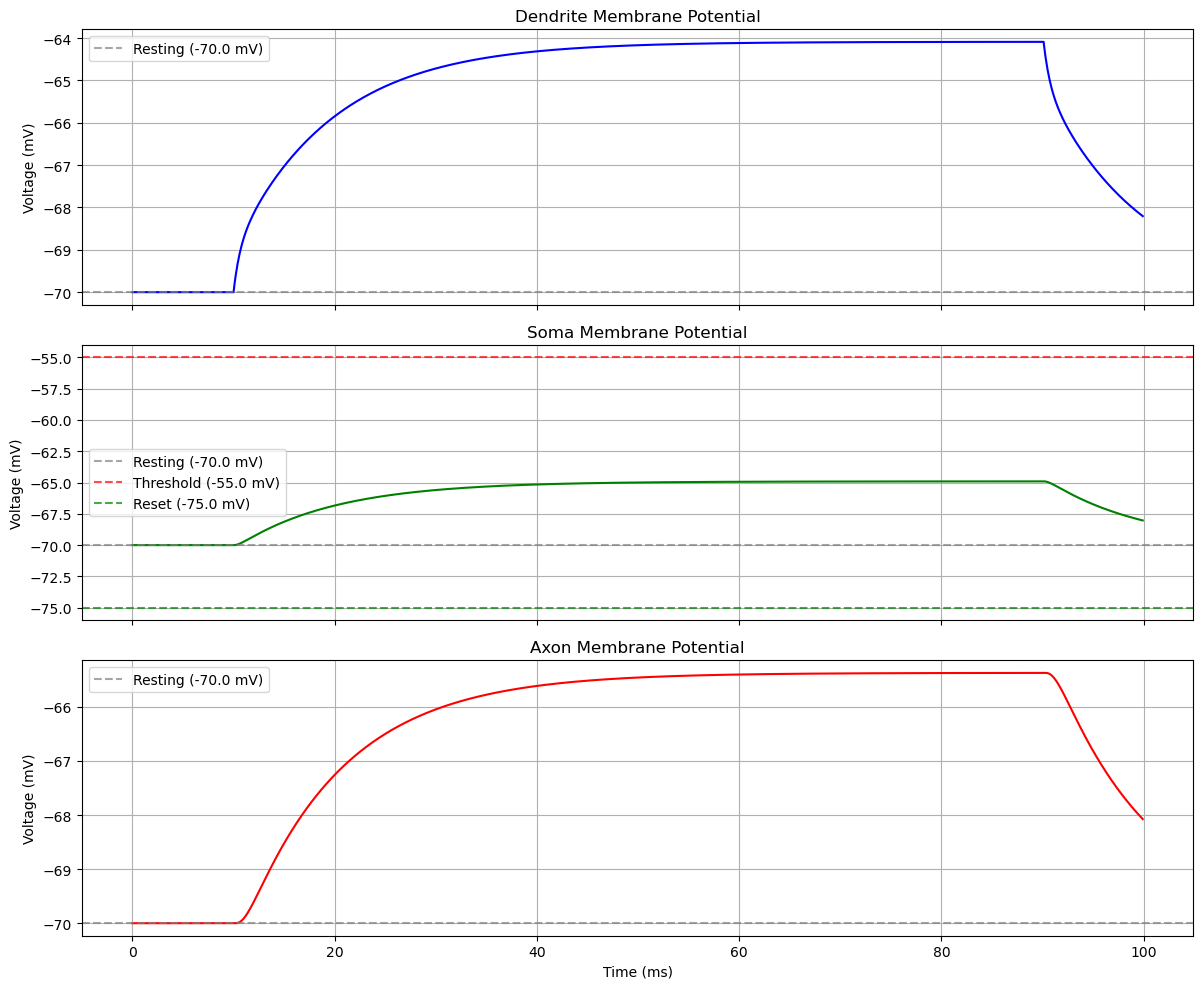

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class CompartmentalNeuron:
    def __init__(self, time_steps):
        # Time parameters
        self.time_steps = time_steps
        self.dt = time_steps[1] - time_steps[0]
        
        # Number of compartments (dendrite, soma, axon)
        self.n_compartments = 3
        
        # Membrane capacitance for each compartment (nF)
        self.Cm = np.array([1.0, 2.0, 0.5])
        
        # Membrane resistance for each compartment (MΩ)
        self.Rm = np.array([5.0, 10.0, 15.0])
        
        # Axial resistance between compartments (MΩ)
        # [R_dendrite_soma, R_soma_axon]
        self.Ra = np.array([1.0, 1.5])
        
        # Resting potential (mV)
        self.V_rest = -70.0
        
        # Threshold and reset (for spike generation in soma)
        self.V_th = -55.0
        self.V_reset = -75.0
        
        # Time constant for each compartment (ms)
        self.tau_m = self.Rm * self.Cm
        
    def simulate(self, I_inj):
        """
        Simulate the compartmental model.
        
        Parameters:
        -----------
        I_inj : array-like
            Input current to each compartment at each time step.
            Shape should be (n_compartments, len(time_steps))
        
        Returns:
        --------
        V : ndarray
            Membrane potential for each compartment at each time step.
            Shape: (n_compartments, len(time_steps))
        spikes : list
            Times when the soma compartment spiked.
        """
        # Initialize voltage array (compartments × time steps)
        V = np.ones((self.n_compartments, len(self.time_steps))) * self.V_rest
        spikes = []
        
        # Simulate for each time step
        for t_idx in range(len(self.time_steps) - 1):
            # Calculate axial currents between compartments
            I_axial = np.zeros(self.n_compartments)
            
            # Dendrite to soma current
            I_dendrite_soma = (V[0, t_idx] - V[1, t_idx]) / self.Ra[0]
            I_axial[0] -= I_dendrite_soma  # Current leaving dendrite
            I_axial[1] += I_dendrite_soma  # Current entering soma
            
            # Soma to axon current
            I_soma_axon = (V[1, t_idx] - V[2, t_idx]) / self.Ra[1]
            I_axial[1] -= I_soma_axon  # Current leaving soma
            I_axial[2] += I_soma_axon  # Current entering axon
            
            # Update voltage for each compartment
            for i in range(self.n_compartments):
                # Calculate leak current
                I_leak = (self.V_rest - V[i, t_idx]) / self.Rm[i]
                
                # Total current = injected + axial + leak
                I_total = I_inj[i, t_idx] + I_axial[i] + I_leak
                
                # Update voltage using Euler method
                dV = (I_total / self.Cm[i]) * self.dt
                V[i, t_idx + 1] = V[i, t_idx] + dV
            
            # Check for spike in soma compartment
            if V[1, t_idx + 1] >= self.V_th:
                spikes.append(self.time_steps[t_idx + 1])
                V[1, t_idx + 1] = self.V_reset
        
        return V, spikes
    
    def plot_results(self, V, spikes):
        """Plot the simulation results."""
        compartment_names = ['Dendrite', 'Soma', 'Axon']
        colors = ['blue', 'green', 'red']
        
        fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
        
        for i in range(self.n_compartments):
            axes[i].plot(self.time_steps, V[i, :], color=colors[i])
            axes[i].set_ylabel('Voltage (mV)')
            axes[i].set_title(f'{compartment_names[i]} Membrane Potential')
            axes[i].grid(True)
            
            # Add horizontal line for resting potential
            axes[i].axhline(y=self.V_rest, color='gray', linestyle='--', alpha=0.7, 
                           label=f'Resting ({self.V_rest} mV)')
            
            # For soma, add threshold line and spikes
            if i == 1:
                axes[i].axhline(y=self.V_th, color='red', linestyle='--', alpha=0.7,
                               label=f'Threshold ({self.V_th} mV)')
                axes[i].axhline(y=self.V_reset, color='green', linestyle='--', alpha=0.7,
                               label=f'Reset ({self.V_reset} mV)')
                for spike in spikes:
                    axes[i].axvline(x=spike, color='red', alpha=0.5)
            
            axes[i].legend()
        
        axes[-1].set_xlabel('Time (ms)')
        plt.tight_layout()
        plt.show()


# Example usage
if __name__ == "__main__":
    # Set up simulation parameters
    t_max = 100  # ms
    dt = 0.1  # ms
    time_steps = np.arange(0, t_max, dt)
    
    # Create neuron
    neuron = CompartmentalNeuron(time_steps)
    
    # Create input current (only to dendrite)
    I_inj = np.zeros((3, len(time_steps)))
    
    # Add a step current to the dendrite
    start_time = 10  # ms
    end_time = 90  # ms
    I_magnitude = 2.0  # nA
    
    I_inj[0, (time_steps >= start_time) & (time_steps <= end_time)] = I_magnitude
    
    # Run simulation
    V, spikes = neuron.simulate(I_inj)
    
    # Plot results
    neuron.plot_results(V, spikes)